この notebook の内容を使った講座の配信 URL は https://youtube.com/live/94dWlMigwYM?feature=share です

In [2]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

%matplotlib inline


# ref: Kaggleコード遺産 https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
# 再現性確保!
seed_everything(510)

In [3]:
from pathlib import Path
# data_dir
DATA_DIR = Path("../data/")

# 学習用のログデータと正解ラベル
train_log_df = pd.read_csv(DATA_DIR / "train_log.csv")
train_label_df = pd.read_csv(DATA_DIR / "train_label.csv")

# 宿のデータ
yado_df = pd.read_csv(DATA_DIR / "yado.csv")

# テスト期間のログデータ
test_log_df = pd.read_csv(DATA_DIR / "test_log.csv")

sample_submission_df = pd.read_csv(DATA_DIR / "sample_submission.csv")

# 画像のデータ
image_df = pd.read_parquet(DATA_DIR / "image_embeddings.parquet")

In [4]:
# すべてのログデータはあとあと参照をするので先に作っておきます.
whole_log_df = pd.concat([train_log_df, test_log_df], ignore_index=True)

## セッションごとの宿候補の作成を深堀する

講座#1ではランダムに組み合わせを作っていました。ただこの候補は「候補に無いものは絶対に予想されない」ため、予測性能を考える上で大変重要です。

候補の選び方が需要なのは、ルールベースで機械学習を使わずともいい感じに候補さえ作ってしまえばそれなりの性能が出てしまうことからもわかるでしょう。例えば @nasuka さんの [機械学習を使わないベースライン(LB: 0.3799)](https://www.guruguru.science/competitions/22/discussions/3ed58bd1-8d35-40e6-8202-db69ac858b3a/) や 
@yutypo さんの [最終閲覧の宿に対する予約された宿の件数の上位から予測値を選ぶ(LB: 0.4199)](https://www.guruguru.science/competitions/22/discussions/3e9bfd60-2a43-452d-9f18-db37d20b77a1/) は候補を特定の方法で選ぶと 0.3 後半のスコアはでるということを示している良い例になっています。(ちなみに前回の初心者向け講座のスコアは機械学習で予約確率を予測していますが LB スコアは 0.15 程度で全然勝てません)

そう **ランダムだなんて!とんでもない!!** のです。

今回の講座では、この候補の組み合わせをより深掘りしてみます! 

### 候補の選び方・場所による制限を考える

@camaroさんのディスカッション [北海道見てたのに沖縄予約するやつ](https://www.guruguru.science/competitions/22/discussions/36d1d0c2-90eb-47a8-bb52-eade889fd91c/) によると、セッションの一番最後の宿と予約された宿の広域CDが違う予約はほとんどなく、県CDが違う予約も殆どないとのことです。確かに予約する地方が大きく変わるってあまり想像ができないですよね。

最後の宿と予約された宿の関係を見てみましょう。

<Axes: xlabel='target_wid_cd', ylabel='last_wid_cd'>

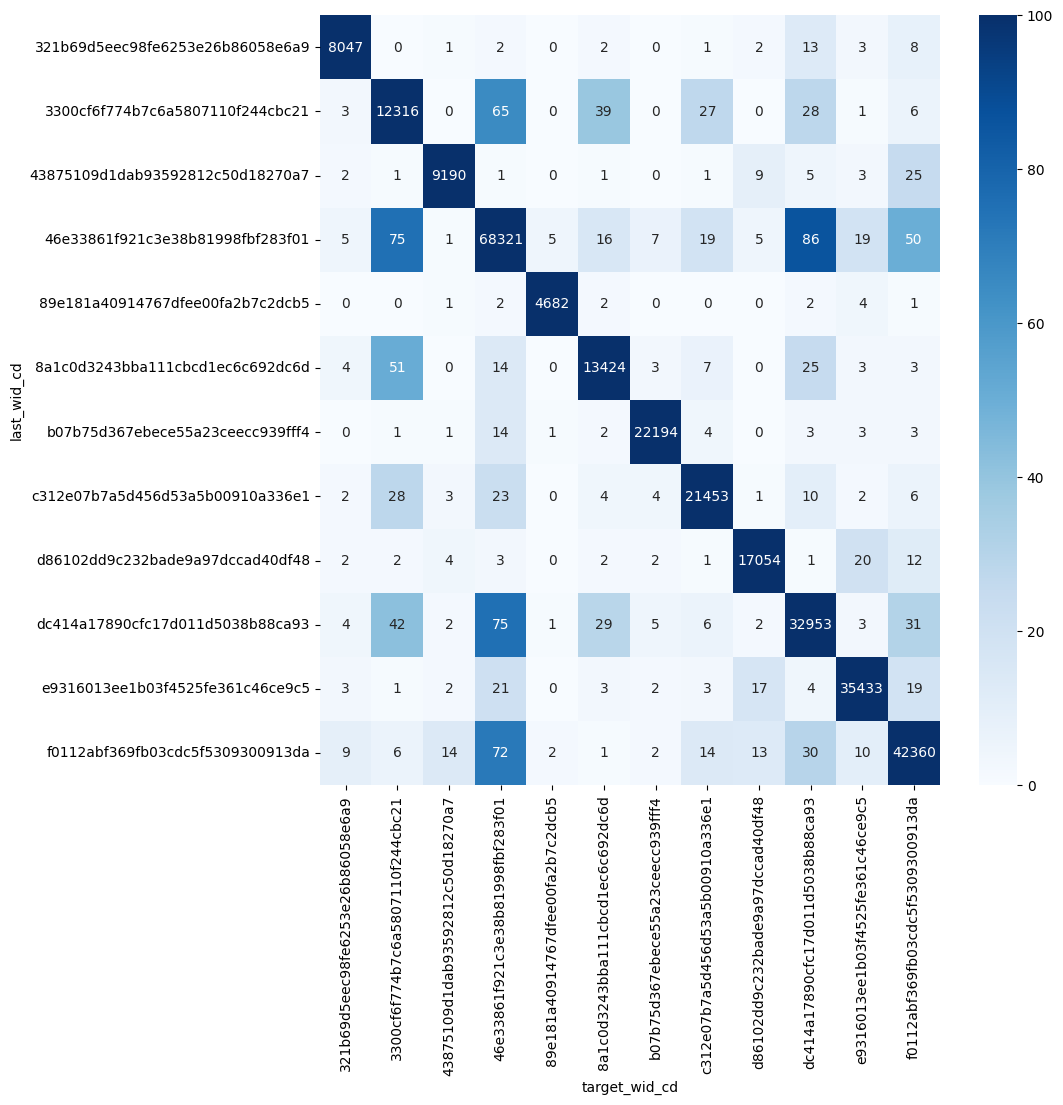

In [5]:
# 一番最後の宿Noは, groupby 後に `last` を使うと取得することができます.
last_yado_df = train_log_df.groupby("session_id").last().reset_index()

# 宿 master と紐づけて wid_cd などを参照できるように
last_yado_df = pd.merge(last_yado_df, yado_df, on="yad_no", how="left")

# 正解ラベルについても同様に
target_yado_df = pd.merge(train_label_df, yado_df, on="yad_no", how="left")

# たとえば wid が一緒かどうかを見てみます.
target_cd = "wid_cd"
_df = pd.concat([last_yado_df[[target_cd]].add_prefix("last_"), 
                 target_yado_df[[target_cd]].add_prefix("target_")], axis=1)
z = _df.groupby(_df.columns.tolist()).size().unstack().fillna(0).astype(int)

# heatmap にして可視化をしてみましょう
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(z, ax=ax, cmap="Blues", annot=True, fmt=".0f", vmax=100)

In [6]:
# 最後の宿と予約の宿が一緒の割合は, target_cd の値が一致しているレコードの比率で出せますね.
idx_same = last_yado_df[target_cd] == target_yado_df[target_cd]

print(f"{target_cd}が同じ割合: {idx_same.mean():.4f}")

wid_cdが同じ割合: 0.9956


これを見ると 99.5% は同一の wid から選ばれています。ということは候補集合に wid が違うものを出すのは意味がなさそうですね。

ルールベースでのアプローチの結果を見てみると、たとえば @nasuka さんのルールベースでの解法では、同一県のなかで人気なもので穴埋めをしています。そしてこのルールのスコアは 0.379 とそれなりに高いです。(前回の初心者向け講座のスコアは 0.15 でした…) この結果からも、ログに出現する宿と近い場所かつ人気な宿を候補にして、その中でランクを付けて上のものを予測するというアプローチが有効そうであることがわかります。

In [7]:

# 宿の出現回数を計算
yad_count = train_log_df.groupby("yad_no").size().rename("yad_count").reset_index()

# 宿のマスター情報を紐づけて
_df = pd.merge(yad_count, yado_df, on="yad_no", how="left")

# 出現回数が多い順に並び替え
_df = _df.sort_values("yad_count", ascending=False)

# この状態で県CDごとに上位30件を取得する
ken_top_30 = _df.groupby("ken_cd").head(30)

# 本当に30件になっている? → なってそう
ken_top_30.groupby("ken_cd").size()

ken_cd
013592a15b9a689232792f11da797ac7    30
06a6febd7478c1aa664ed5ac87f2d560    30
072c85e1653e10c9c7dd065ad007125a    30
0745a2107686fcb724892ce52f19d02e    30
0a66f6ab9c0507059da6f22a0e1f1690    30
107c7305a74c8dcc4f143de208bf7ec2    30
21a8fca457386861964bea1ffa848fdd    30
223938a74a609968141867c244086206    30
2b99151dba9558109a35c75a3c05c38b    30
31a0f630d36db568ab23c9c1cd80d1c1    30
3831f43bb997a3028669c251c2c2f552    30
39c3eb151762dd35cf50e8bde404ae74    30
3acaaea4dab8892b5c9832f1b32f9448    30
3b09a7ce9934c00fd266f9cf246308d1    30
470fa9ac04f80c7e13db398668e124bf    30
517061b8165aa6370d9025951a64aa52    30
543ea7c443fdfd779bbd557f2ad99d80    30
558ac1909f0318b82c621ab250329d6d    30
572d60f0f5212aacda515ebf81fb0a3a    30
6692a692f80687411022c08e4f5a7a00    30
66c4d01ad8e30155582cf80b1d655986    30
689cf8289e7ea0b2eef1b017dcdfe8de    30
6920865be128aa14814810654738b159    30
6d279eafce12f1a118fe7cbaa74f105a    30
75617bb07a2785a948ab1958909211f1    30
7bc5fba93082f02f1c

In [8]:
# 個別に `013592a15b9a689232792f11da797ac7` を見てみて確認
ken_top_30[ken_top_30["ken_cd"] == "013592a15b9a689232792f11da797ac7"]

,yad_no,yad_count,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
5975,6164,214,0,64.0,1.0,1,NaN,NaN,NaN,NaN,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
7407,7649,187,0,173.0,1.0,1,NaN,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
1185,1227,183,0,233.0,1.0,1,1.0,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,989ce3ae2fc5f1649bd10e05917a27f8,ed85e7b17b271de96e7e22ab2bff4aa7
5171,5331,142,0,119.0,1.0,0,NaN,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,989ce3ae2fc5f1649bd10e05917a27f8,ed85e7b17b271de96e7e22ab2bff4aa7
10721,11077,128,0,183.0,1.0,1,NaN,NaN,NaN,NaN,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,6d7e40c7eae769872f8e1388097f2a62,73d0b2ebb84e0ae35e1ec6c0d64dff81
5882,6069,127,0,120.0,1.0,1,NaN,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
4644,4785,125,0,31.0,1.0,1,NaN,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,6d7e40c7eae769872f8e1388097f2a62,73d0b2ebb84e0ae35e1ec6c0d64dff81
8366,8646,121,0,NaN,1.0,1,NaN,NaN,NaN,NaN,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
7917,8173,118,0,47.0,1.0,1,NaN,NaN,NaN,NaN,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
2452,2529,116,0,72.0,1.0,1,NaN,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,6d7e40c7eae769872f8e1388097f2a62,73d0b2ebb84e0ae35e1ec6c0d64dff81


これを組み込んで session-yad の組み合わせを作ってみましょう〜

In [9]:
# セッションの一番最後の宿に, yado情報を紐付ける
session_last = pd.merge(train_log_df.groupby("session_id").last().reset_index(), 
                        yado_df, on="yad_no", how="left")

# 県の上位30この宿を一番最後の宿情報 `session_last` に紐づけ
out_df = pd.merge(session_last[["session_id", "ken_cd"]], 
         ken_top_30[["ken_cd", "yad_no"]], on="ken_cd", how="left")

# 使うのはセッションと宿の関係
out_df = out_df[["session_id", "yad_no"]].copy()

train_log_df でうまく動くようにかけたので, これを関数化します。

In [10]:
def create_session_yad_df(input_df: pd.DataFrame):
    """input_df には train_log / test_log のいずれかが来ることを想定している"""
    
    # セッションの一番最後の宿に, yado情報を紐付ける
    session_last = pd.merge(input_df.groupby("session_id").last().reset_index(), 
                            yado_df, on="yad_no", how="left")

    # 県の上位30この宿を一番最後の宿情報 `session_last` に紐づけ
    out_df = pd.merge(session_last[["session_id", "ken_cd"]], 
             ken_top_30[["ken_cd", "yad_no"]], on="ken_cd", how="left")

    # 使うのはセッションと宿の関係
    out_df = out_df[["session_id", "yad_no"]].copy()
    
    # ランダムに付け加えたもの以外・同一ログに出現する宿を候補にいれる
    out_df = pd.concat([out_df, input_df[["session_id", "yad_no"]]], ignore_index=True)
    
    # 重複は意味がないので消します。
    out_df = out_df.drop_duplicates()
    
    # 見た目を揃えるために session / yad の順番でソートをします
    out_df = out_df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)
    
    return out_df 

In [11]:
with Timer(prefix="train session yado..."):
    train_session_yad_df = create_session_yad_df(input_df=train_log_df)

# 予測の際には session ごとに yado に対しての予約確率を出さなくてはなりませんから、同じように session - yado の組を作ります。
# ただし学習時と同じような組で良いか? は議論が必要かもしれません. (ここに現れない宿は予測対象に絶対入らないため)
with Timer(prefix="test session yado..."):
    test_session_yad_df = create_session_yad_df(input_df=test_log_df)

train session yado... 5.337[s]
test session yado... 2.512[s]


今回は単純に県が同じもの、を候補に追加しました。これ以外にも色々と良い候補の作り方は考えられますのでぜひオリジナルの工夫をしてみてください!

> 例えば @zakopuro さんの [Lightgbm ReRank Model BaseLine(LB:0.4158)](https://www.guruguru.science/competitions/22/discussions/20c54ca7-a389-43b0-9028-92011fb52fd5/) のようにより凝った候補を作って紐づける方法が提案されています。

### note: 候補のクオリティを考える

今回は同一の県CDで人気30件の宿を候補として採用しましたが、この候補はたくさん考えることができます。それらの良さ (クオリティ) を測れると新しいアイディアが良いか悪いかを判断できて嬉しいですね。

その一つとして、候補の中にどのぐらい正解の宿が入っているかというものがあるでしょう。

> @column2131 さんの discussion [CV vs LB](https://www.guruguru.science/competitions/22/discussions/5156955c-34b0-454f-a4c5-565e62d16b98/) ではヒット率という言い方をされていました。

In [12]:
_df = pd.merge(train_session_yad_df[["session_id"]], 
               train_label_df, on="session_id", how="left")
has_truth_yado = (train_session_yad_df["yad_no"] == _df["yad_no"]).groupby(train_session_yad_df["session_id"]).sum()

In [13]:
has_truth_yado.mean()

0.5109110558438229

### 学習用データへの後処理

今回はあえて train label を付与していません。これは学習時のバイアスを取り除くことが狙いの一つです。(後述)

In [14]:
# 正解ラベル train_label_df の組み合わせを付与
_df = pd.concat([train_session_yad_df], ignore_index=True)

# 重複を削除して
_df = _df.drop_duplicates().reset_index(drop=True)

# 正解ラベルに含まれているレコードの index を配列で取得して
target_index = pd.merge(_df.reset_index(), train_label_df, on=["session_id", "yad_no"], how="inner")["index"].values

# 正解Indexに含まれている場合 1 / そうでないと 0 のラベルを作成
_df["target"] = _df.index.isin(target_index).astype(int)

# 見た目を揃えるために session / yad でソートしておく
_df = _df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

train_session_yad_df = _df.copy()

<Axes: xlabel='yad_no'>

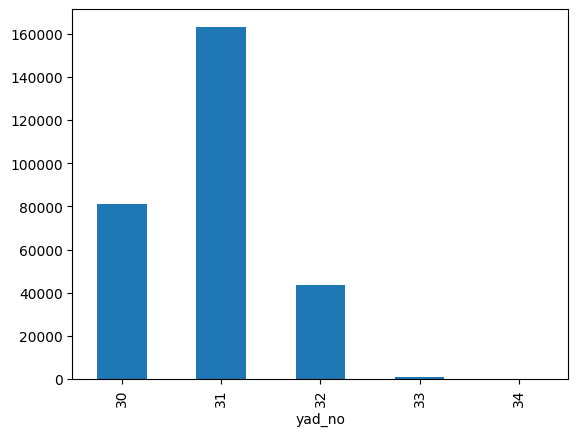

In [15]:
train_session_yad_df.groupby("session_id")["yad_no"].nunique().value_counts().sort_index().plot(kind="bar")

### テストデータへの後処理: ログの一番最後の宿の削除

テスト用データは最終的に「この宿に泊まってる?」を予測する対象になる宿を定義することになります。今回のデータは「ログデータの一番最後の宿は必ず正解ラベルではない」という制約条件があるので、セッションの最後の宿は取り去る処理を行っておきましょう。

In [16]:
def remove_last_yad_id(session_yad_df):
    
    # セッション中一番最後の宿の組を作成
    last_yad_df = whole_log_df.groupby("session_id").tail(1)[["session_id", "yad_no"]]
    
    # 最後であることがわかるようにラベル is_last を付与
    last_yad_df["is_last"] = 1
    
    # 引数の session - yad の組み合わせとマージして
    merged = session_yad_df.merge(last_yad_df, on=["session_id", "yad_no"], how="left")
    
    # is_last **ではない** (i.e. is_last is null) データのみに絞る
    idx_use = merged["is_last"].isnull()
    out_df = session_yad_df[idx_use].reset_index(drop=True)
    
    return out_df

test_session_yad_df = remove_last_yad_id(test_session_yad_df)

<Axes: xlabel='yad_no'>

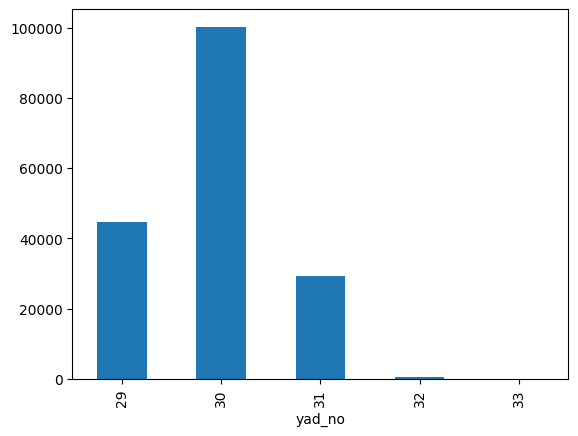

In [17]:
test_session_yad_df.groupby("session_id")["yad_no"].nunique().value_counts().sort_index().plot(kind="bar")

## 特徴量の作成

In [18]:
# ======= 1:セッションが持つ情報 -- セッションの長さ情報 =======
session_length = whole_log_df.groupby("session_id")["seq_no"].max()

def create_session_length_feature(input_df: pd.DataFrame):
    session_length = whole_log_df.groupby("session_id")["seq_no"].max().rename("session_length")
    
    out_df = pd.merge(input_df["session_id"], session_length, on="session_id", how="left").drop(columns=["session_id"])
    return out_df

# 2回同じ関数を使って特徴を作ったとき同一のデータができるか? をテストしておくと少し安心です
assert create_session_length_feature(train_session_yad_df).equals(create_session_length_feature(train_session_yad_df))

# ======= 2:宿の情報 -- 数値系特徴 =======
def create_yado_numaric_feature(input_df: pd.DataFrame):
    num_columns = [
        'yad_type',
        'total_room_cnt',
        'wireless_lan_flg',
        'onsen_flg',
        'kd_stn_5min',
        'kd_bch_5min',
        'kd_slp_5min',
        'kd_conv_walk_5min',
    ]
    
    # key となる `yad_no` を付与するのをお忘れなく.
    out_df = pd.merge(input_df["yad_no"], yado_df[["yad_no", *num_columns]], how="left").drop(columns=["yad_no"])
    return out_df

assert create_yado_numaric_feature(train_session_yad_df).equals(create_yado_numaric_feature(train_session_yad_df))


# ======= 3: 宿の情報 -- wid cd の label encoding =======
# LabelEncoding は scikit-learn に変換ロジックが用意されていますのでそれを利用するのが便利です。
from sklearn.preprocessing import LabelEncoder

# 使い方はシンプルで, LabelEncoder を定義したあと fit_trainsform で与えられた配列を数値 Label に変換します。
le = LabelEncoder()

wid_cd_label = le.fit_transform(yado_df["wid_cd"])
wid_cd_label

def create_yad_wid_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame({
        "yad_no": yado_df["yad_no"],
        "wid_cd_label": wid_cd_label
    })
    
    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(columns=["yad_no"])
    return out_df

assert create_yad_wid_cd_feature(train_session_yad_df).equals(create_yad_wid_cd_feature(train_session_yad_df))

## より凝った特徴を考える

### 宿とセッションの組み合わせの特徴量: この宿ログにある??

前回は宿やセッションが単体で持つ特徴を考えました。より発展的な情報量として、これを同時に考えた情報も特徴量として加えることができます。例えばですが「このセッション内のログにこの宿Noは入っているか?」などが該当します。今予測しようとしている宿がセッションに入っているとそれは予約率が上がりそうですね。

In [19]:
train_session_yad_df.head()

,session_id,yad_no,target
0,000007603d533d30453cc45d0f3d119f,1050,0
1,000007603d533d30453cc45d0f3d119f,1070,0
2,000007603d533d30453cc45d0f3d119f,1679,0
3,000007603d533d30453cc45d0f3d119f,2395,0
4,000007603d533d30453cc45d0f3d119f,2424,0


In [20]:
def create_is_in_log_feature(input_df):
    # 持っているログデータ全体に入っているものに `is_in_log` というフラグを付与
    _df = whole_log_df[["session_id", "yad_no"]].copy().drop_duplicates().reset_index(drop=True)
    _df["is_in_log"] = 1
    
    # 入力された session - yado と紐づける. 
    # ログにない場合には `is_in_log` は欠損 (Nan) するので 0 で穴埋めして 0-1 のフラグにする
    out_df = pd.merge(input_df, _df, on=["session_id", "yad_no"], how="left")[["is_in_log"]].fillna(0)
    
    return out_df

In [21]:
create_is_in_log_feature(train_session_yad_df).head()

,is_in_log
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0


In [22]:
create_is_in_log_feature(train_session_yad_df).mean()

is_in_log    0.044664
dtype: float64

宿Noだと、たまたまその宿を見ていないと一致しないのでちょっと厳しい条件かもしれないですね。

discussion を見ていると, 同じ地域で宿を探しているセッションが多そうということがわかっていますから、例えば「対象の宿と同じ地域を見てるか?」を特徴にすると同じ地域かどうか、をモデルが判断できて良いかもしれません。

In [23]:
# --- 実装のスケッチ ---

# 0: 地域のカラム名を指定(あとでべつの列でもできるように!)
region_column = "sml_cd"

# 1: セッション宿に地域を紐づけ
session_yad_region_df = pd.merge(train_session_yad_df, yado_df[["yad_no", region_column]], on="yad_no", how="left")

# 2: ログデータを使って, セッションの一番最後のレコードに地域を紐づけ
#   - セッションの一番最後の行のみを取り出して
last_session_yad_df = whole_log_df.groupby("session_id")["yad_no"].last().reset_index()

#   - 宿マスターから地域を紐づけ
last_session_yad_df = pd.merge(last_session_yad_df, yado_df[["yad_no", region_column]], on="yad_no", how="left")

# 3: セッション宿のセッションに, 一番最後の宿の地域を紐づけ
last_yad_region = pd.merge(session_yad_region_df["session_id"], 
                           last_session_yad_df[["session_id", region_column]], 
                           how="left")[region_column]

# 4: 1 と 3 の地域が一致している == 一番最後の宿の地域と候補の宿の地域が一緒!
session_yad_region_df[region_column] == last_yad_region

0          False
1          False
2          False
3           True
4          False
           ...  
8914267    False
8914268    False
8914269    False
8914270    False
8914271    False
Name: sml_cd, Length: 8914272, dtype: bool

In [24]:
def create_option_yad_and_last_yado_is_same_region_feature(input_df):

    # 0: 地域のカラム名を指定(あとでべつの列でもできるように!)
    region_column = "sml_cd"

    # 1: セッション宿に地域を紐づけ
    session_yad_region_df = pd.merge(input_df, 
                                     yado_df[["yad_no", region_column]], on="yad_no", how="left")

    # 2: ログデータを使って, セッションの一番最後のレコードに地域を紐づけ
    #   - セッションの一番最後の行のみを取り出して
    last_session_yad_df = whole_log_df.groupby("session_id")["yad_no"].last().reset_index()

    #   - 宿マスターから地域を紐づけ
    last_session_yad_df = pd.merge(last_session_yad_df, yado_df[["yad_no", region_column]], on="yad_no", how="left")

    # 3: セッション宿のセッションに, 一番最後の宿の地域を紐づけ
    last_yad_region = pd.merge(session_yad_region_df["session_id"], 
                               last_session_yad_df[["session_id", region_column]], 
                               how="left")[region_column]

    # 4: 1 と 3 の地域が一致している == 一番最後の宿の地域と候補の宿の地域が一緒!
    idx = session_yad_region_df[region_column] == last_yad_region
    
    out_df = pd.DataFrame({
        "same": idx.astype(int)
    }).add_prefix(f"{region_column}_is_")
    
    return out_df

In [25]:
assert create_option_yad_and_last_yado_is_same_region_feature(test_session_yad_df)\
    .equals(create_option_yad_and_last_yado_is_same_region_feature(test_session_yad_df))

### 全部の情報は使うぞ: 画像の特徴を使う

> 個人的に、画像のembeddingデータを使ったモデルの構築方法を知りたいです…

前回は完全にスキップしていましたが、与えられた情報の中には画像の embedding 情報もあります。使わないのはもったいないですね。

In [26]:
image_df.head()

,yad_no,category,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
0,1,exterior,-0.010736,-0.055452,-0.034968,0.052371,0.013423,0.037117,0.098775,0.074732,...,-0.039645,0.047950,-0.001786,-0.054268,-0.173725,-0.037862,-0.039419,0.039463,-0.071842,-0.007374
1,1,exterior,0.056188,-0.026121,-0.056543,0.022742,-0.046260,0.020954,0.006757,-0.010403,...,-0.001135,0.019452,-0.158739,0.069106,-0.314221,-0.014093,0.020678,0.058678,0.027612,-0.007790
2,1,exterior,0.059149,0.007443,-0.050527,0.031444,-0.034918,0.018043,0.016075,-0.000287,...,-0.017606,0.028306,-0.153259,0.079555,-0.305520,-0.034372,0.037976,0.065278,0.023551,-0.006770
3,1,facility,-0.008016,0.031106,-0.013940,0.013397,-0.025822,0.020344,0.049135,-0.031101,...,-0.029366,-0.035536,-0.098193,0.031702,-0.359215,-0.041691,0.002394,-0.022892,-0.039722,-0.013380
4,1,facility,0.010669,-0.000045,0.002484,0.008006,-0.041051,0.022130,0.026998,0.011513,...,-0.008329,-0.025674,-0.175958,0.052703,-0.350555,-0.035050,-0.029618,0.010537,-0.040529,-0.031906


<Axes: xlabel='category'>

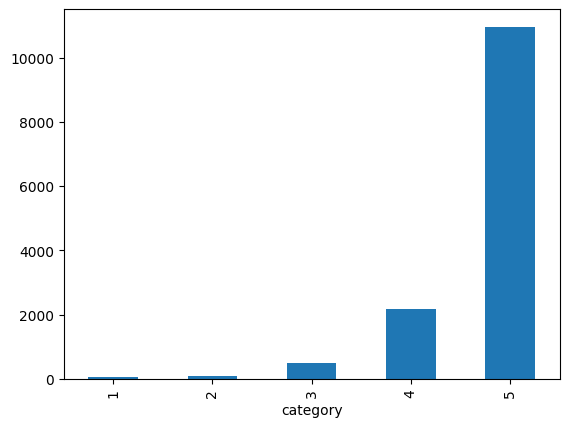

In [27]:
image_df.groupby("yad_no")["category"].nunique().sort_values().value_counts().sort_index().plot(kind="bar")

画像は一つの宿に対して複数紐づいているので、何らか集約をする必要があります。めちゃくちゃシンプルにやるなら min / max などの集約関数を通すやり方があるでしょう. 

In [28]:
emb_columns = [s for s in image_df.columns.tolist() if "emb" in s]
image_df.groupby("yad_no")[emb_columns].min()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
yad_no,,,,,,,,,,,,,,,,,,,,,
1,-0.037200,-0.057255,-0.056543,-0.028323,-0.101417,-0.040709,-0.033629,-0.032371,-0.026507,-0.069944,...,-0.039645,-0.035536,-0.175958,-0.061051,-0.359215,-0.047629,-0.039601,-0.047809,-0.071842,-0.043084
2,-0.038669,-0.030190,-0.035665,-0.064840,-0.080834,-0.054236,-0.042528,-0.052566,-0.060701,-0.040175,...,-0.047399,-0.060039,-0.150361,-0.077267,-0.347712,-0.070468,-0.059483,-0.088799,-0.017178,-0.072243
3,-0.023177,-0.039656,-0.028291,-0.019827,-0.098171,-0.030859,-0.034548,-0.077161,-0.057538,-0.037286,...,-0.047663,-0.046045,-0.138281,-0.087606,-0.406311,-0.068986,-0.038933,-0.058962,-0.026506,-0.036826
4,-0.068744,-0.047429,-0.067256,-0.041668,-0.082009,-0.045475,-0.042378,-0.051579,-0.044365,-0.039852,...,-0.027083,-0.027925,-0.164499,-0.103130,-0.386344,-0.057975,-0.023044,-0.065556,-0.153507,-0.039060
5,-0.097115,-0.010818,-0.057803,-0.036588,-0.118123,-0.077922,-0.012545,-0.033398,-0.149741,-0.077266,...,-0.036381,-0.056794,-0.116022,-0.097249,-0.355593,-0.081870,-0.043299,-0.096033,-0.036269,-0.055251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13802,-0.031192,-0.040603,-0.065945,-0.035399,-0.056453,-0.044835,-0.008783,-0.036229,-0.116063,-0.064191,...,-0.017953,-0.058666,-0.144928,-0.128571,-0.375489,-0.076609,-0.043291,-0.054533,-0.036349,-0.046314
13803,-0.024467,-0.057539,-0.038662,0.005614,-0.092965,-0.030548,-0.033675,-0.062009,-0.070334,-0.060690,...,-0.021311,-0.050022,-0.122312,-0.031142,-0.406309,-0.076503,-0.053203,-0.042033,-0.024968,-0.049659
13804,-0.026491,-0.037895,-0.026476,-0.029740,-0.086030,-0.080269,-0.048862,-0.042981,-0.085097,-0.090111,...,-0.054214,-0.031470,-0.139748,-0.061569,-0.384251,-0.064341,-0.036068,-0.076327,-0.014744,-0.026141


これを session - yado の yado_no で join すると今予測対象になっている宿の画像、という特徴量として利用することができます。ただ 512 次元はちょっと大きすぎるきらいがありますので、次元圧縮の手法でよりギュッと圧縮した情報を使います。

> note: LightGBM などの GBDT 系モデルは特徴が増えてもそれなりには動くのですが、あまり意味がない情報が増えると計算時間ばかりかかってしまい、試行回数のイテレーションが回せなくなってしまいます。そのため画像の embedding など次元数が多いものは次元圧縮して利用することが多いです。

次元圧縮には、よく使われる TruncatedSVD を利用します

In [29]:
from sklearn.decomposition import TruncatedSVD

In [30]:
# 今回は 32 次元にすることにしました
img_svd = TruncatedSVD(n_components=32)

# 使い方は簡単で, shape = (n_data, n_features,) の numpy 配列を渡せばOKです
z = img_svd.fit_transform(image_df[emb_columns].values)

# 今回は 32 次元を指定したので z は (n_data, 32,) 次元の配列になります
# 512 → 32 次元に圧縮ができました!
z.shape

(178406, 32)

In [31]:
# session - yado と紐付けるときは一度代表値による集約をして yado ごとの特徴に変換します (今回は max)
svd_img_df = pd.DataFrame(data=z)
max_svd_df = svd_img_df.groupby(image_df["yad_no"]).max()

# その後 yad_no で left join!
pd.merge(train_session_yad_df["yad_no"], max_svd_df, on="yad_no", how="left").drop(columns=["yad_no"])

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.799066,0.249712,0.395857,0.313937,0.112595,0.006046,0.197873,0.195366,0.235127,0.209570,...,0.111942,0.050131,0.093560,0.077831,0.099657,0.095322,0.024953,0.142729,0.118042,-0.023132
1,0.849753,0.329471,0.542548,0.296774,0.318526,0.277339,0.291379,0.256612,0.265943,0.175351,...,0.074207,0.091206,0.040322,0.059427,0.094778,0.042522,0.133434,0.073480,0.028499,0.073925
2,0.807748,0.406683,0.204416,0.438942,0.250365,0.073701,0.206542,0.246098,0.155415,-0.008906,...,0.166619,0.063714,0.093777,0.063698,0.079841,0.094801,0.077623,0.102796,0.075264,0.042146
3,0.812981,0.390100,0.533999,0.276252,0.253336,0.349934,0.254345,0.195943,0.232721,0.138602,...,0.068325,0.170550,0.108252,0.058885,0.114107,0.058284,0.153064,0.138687,0.048498,0.239100
4,0.819419,0.374829,0.534119,0.223044,0.225264,0.194689,0.247435,0.174660,0.249353,0.199332,...,0.107459,0.146584,0.123821,0.076322,0.081588,0.086636,0.040906,0.129129,0.117809,0.048562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8914267,0.819830,0.353886,0.526891,0.266508,0.118968,0.130372,0.222803,0.220199,0.253947,0.150557,...,0.097056,0.197258,0.092411,0.174443,0.082188,0.030860,0.115796,0.080049,0.056061,0.111266
8914268,0.747481,0.366037,0.466706,0.331662,-0.008991,0.150856,0.187767,0.162762,0.140937,0.135638,...,0.085990,0.136493,0.101624,0.062341,0.120436,0.134391,0.125763,0.138687,0.065469,0.239100
8914269,0.777625,0.414778,0.012371,0.254349,0.199607,0.103958,0.212018,0.242371,0.323040,0.010099,...,0.310314,0.114712,0.138916,0.040272,0.113280,0.114700,0.106473,0.069679,0.091478,0.033198
8914270,0.801645,0.413744,0.287878,0.257530,0.291503,0.198703,0.312904,0.180335,0.191182,0.144889,...,0.150009,0.093181,0.065397,0.087076,0.104474,0.111663,0.166024,0.037516,0.083568,0.066188


上記で作った `max_svd_df` があればあとは yad_no と join をするだけなのでシンプルです。

In [32]:
def create_yado_image_feature(input_df):
    out_df = pd.merge(input_df["yad_no"], 
                      max_svd_df, 
                      on="yad_no", how="left").drop(columns=["yad_no"])
    
    return out_df.add_prefix("yad_img_max_")

### Future Work

* 今回は max で集約をしましたが他の集約方法もあるかも?しれません
* 集約する以外でも画像の情報を使う方法はありそうです。例えば単純に画像の件数なども意味がありそうですね (たくさん画像を用意している == じゃらんの掲載にやる気がある宿かも?)

### 特徴量のマージ

上記の特徴量作成関数を連続的に呼び出し & 結合して、学習に使う特徴量全体にしましょう。

In [33]:
# いままでの関数をすべてがっちゃんこして特徴量を作成する関数を定義しましょう!

def create_feature(input_df):

    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_session_length_feature,
        create_yado_numaric_feature,
        create_yad_wid_cd_feature,
        create_is_in_log_feature,
        create_yado_image_feature,
        create_option_yad_and_last_yado_is_same_region_feature,
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"- create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [34]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df = create_feature(train_session_yad_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_session_yad_df)

X = train_feat_df.values
y = train_session_yad_df["target"].values

- create create_session_length_feature 0.921[s]
- create create_yado_numaric_feature 0.717[s]
- create create_yad_wid_cd_feature 0.417[s]
- create create_is_in_log_feature 2.041[s]
- create create_yado_image_feature 2.378[s]
- create create_option_yad_and_last_yado_is_same_region_feature 1.704[s]
train... 9.336[s]
- create create_session_length_feature 0.636[s]
- create create_yado_numaric_feature 0.372[s]
- create create_yad_wid_cd_feature 0.214[s]
- create create_is_in_log_feature 1.010[s]
- create create_yado_image_feature 1.504[s]
- create create_option_yad_and_last_yado_is_same_region_feature 1.136[s]
test... 5.570[s]


## モデルの学習

In [35]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=5)
cv = fold.split(X, y, groups=train_session_yad_df["session_id"].values)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく

import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, \
    r2_score, mean_squared_log_error, median_absolute_error, explained_variance_score, cohen_kappa_score, \
    average_precision_score, precision_score, recall_score


def binary_metrics(y_true: np.ndarray,
                   predict_probability: np.ndarray,
                   threshold=.5) -> dict:
    """
    calculate binary task metrics
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    none_prob_functions = [
        accuracy_score,
        f1_score,
        precision_score,
        recall_score
    ]

    prob_functions = [
        roc_auc_score,
        log_loss,
        average_precision_score
    ]

    scores = {}
    for f in none_prob_functions:
        score = f(y_true, predict_label)
        scores[str(f.__name__)] = score
    for f in prob_functions:
        score = f(y_true, predict_probability)
        scores[f.__name__] = score

    return scores

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        print(f"-- start fold {i}")
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params, verbose=0)

        with Timer(prefix="fit fold={} ".format(i)):

            # cv 内で train に定義された x_train で学習する
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    callbacks=[
                        lgbm.early_stopping(stopping_rounds=50, verbose=True),
                        lgbm.log_evaluation(period=50, ),
                    ],)

        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = binary_metrics(y_valid, pred_i)
        print(f" - fold{i + 1} - {score}")

    score = binary_metrics(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score}")
    return oof_pred, models

In [36]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "binary", 

    # 木の最大数
    "n_estimators": 10000, 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    "learning_rate": .1,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 510,
}

oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

-- start fold 0
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0496182
[100]	valid_0's binary_logloss: 0.0493541
[150]	valid_0's binary_logloss: 0.0492133
[200]	valid_0's binary_logloss: 0.0491364
[250]	valid_0's binary_logloss: 0.0491046
[300]	valid_0's binary_logloss: 0.0490845
[350]	valid_0's binary_logloss: 0.0490782
[400]	valid_0's binary_logloss: 0.0490548
[450]	valid_0's binary_logloss: 0.0490548
Early stopping, best iteration is:
[424]	valid_0's binary_logloss: 0.0490526
fit fold=0  66.798[s]
 - fold1 - {'accuracy_score': 0.9844298721644211, 'f1_score': 0.18716875054903223, 'precision_score': 0.6813046258793434, 'recall_score': 0.10848608282416837, 'roc_auc_score': 0.9318435215893102, 'log_loss': 0.049052625044479096, 'average_precision_score': 0.3949551159996933}
-- start fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0497136
[100]	valid_0's binary_logloss: 0.049472
[150]	valid

## 結果を解釈する

モデルができた! 次は予測だ! の前に… 一度予測結果の見積もりを行いましょう。

### 手元でスコアを見積もる

予測時には 5 Fold に分けてモデルを作りましたので `oof` に含まれるデータは完全に正解情報を知らない状態で予測された確率になっています。これを使って今回の指標 MAP@10 のスコアを見積もって見ましょう。

まずは予測確率ともとのセッション・宿情報から、セッションごとに予測確率の高い宿Noを10件取得しましょう。これはあとでテストデータに対しても同じことをしますので、関数にしておくと便利ですね。

In [37]:
def create_top_10_yad_predict(predict, session_yad_df):
    _df = pd.concat([session_yad_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")], axis=1)
    
    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = _df.sort_values("predict", ascending=False).groupby("session_id")["yad_no"].apply(list)
    
    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    
    return out_df

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [38]:
oof_label_df = create_top_10_yad_predict(predict=oof, session_yad_df=train_session_yad_df)

# いま作成した session_id と同じ並びで train_label を並び替え
train_label = train_label_df.set_index("session_id").loc[oof_label_df.index]["yad_no"].values

# MAPK (k=10) として計算
oof_score = mapk(actual=train_label, predicted=oof_label_df.values.tolist(), k=10)

print(f"OOF Score: {oof_score:.4f}")

OOF Score: 0.2794


学習時の見積もりとして性能は `0.2796` となりました。

前回と比べるとだいぶ現実的な値ですね! (前回は 0.4 を超えたとても高いスコアであったことを思い出してください。)

前回少しお話した学習時のバイアス問題が関与しています。今回の notebook では train label の session-yado を加える、という「正解を知っていないとできない」操作をしなかったため、学習時の枠組みでテストのときのような動きが再現できていることが要因の一つです。

### 特徴重要度の可視化

/tmp/ipykernel_170118/1168668338.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


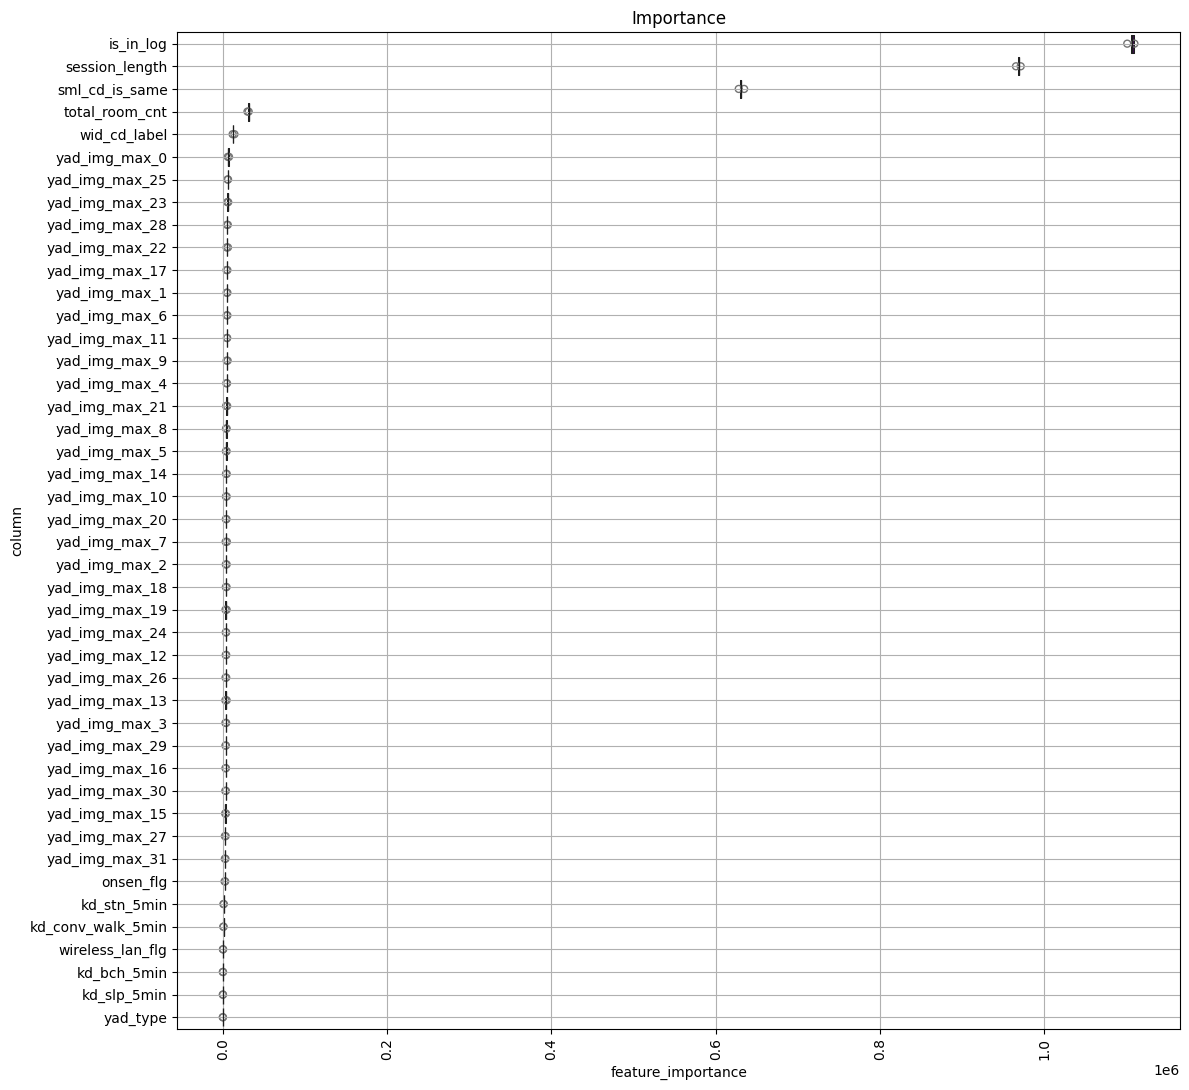

In [39]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

## 推論する

学習したモデルを使ってテストデータに対しての予測を行いましょう。

In [40]:
# k 個のモデルの予測確率 (predict_proba) を作成. shape = (5, N_test,).
pred_prob = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])

In [41]:
# k 個のモデルの予測値の平均 shape = (N_test,).
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる 

### 予測値の確認

予測結果が学習時の結果と差が出ていないかを確認しましょう。具体的には out of fold の予測確率の分布と test への予測確率の分布を見て大きなズレがないかなどを見ると良いです。このとき予期せぬズレが発生している場合には実装が間違っている場合や、テスト時に使えない情報を学習時に使っている場合などがあります。

勢い良く submit をする前に一度確認しておくと良いです🫑( '-' 🫑)

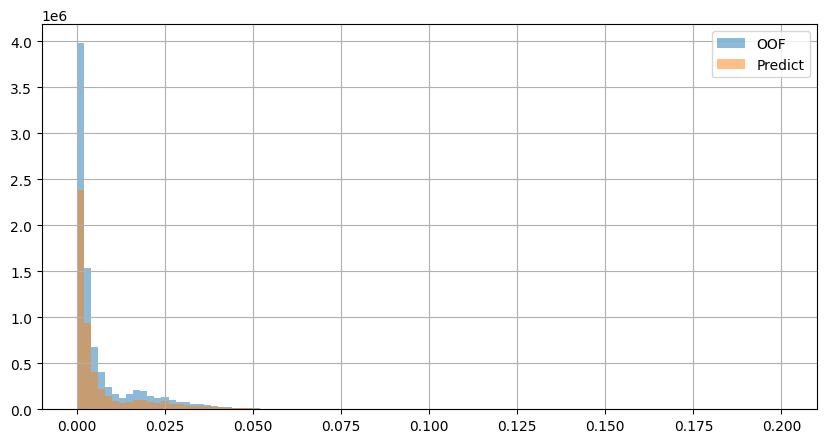

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(0, 0.2, 101)

ax.hist(oof, bins=bins, alpha=.5, label="OOF")
ax.hist(pred_prob, bins=bins, alpha=.5, label="Predict")

ax.legend()
ax.grid()

In [43]:
test_pred_df = create_top_10_yad_predict(predict=pred_prob, session_yad_df=test_session_yad_df)
test_pred_df.iloc[:, :10].fillna(0).astype(int).add_prefix("predict_")\
    .to_csv(os.path.join("../#2_submission.csv"), index=False)

In [44]:
test_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
00001149e9c73985425197104712478c,3560,385,12785,755,109,13292,10883,5066,1169,10418
0000e02747d749a52b7736dfa751e258,10095,12707,3,13131,1229,7169,1091,2974,7093,11919
0000f17ae2628237d78d3a38b009d3be,757,9190,28,2758,850,13027,9015,7345,4882,1558
000174a6f7a569b84c5575760d2e9664,12341,5657,2795,277,6991,2047,3359,4180,9319,2363
00017e2a527901c9c41b1acef525d016,5713,6576,12524,13590,9020,3187,5106,6703,1364,7474
